In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.initializers import GlorotNormal
from mpl_toolkits.mplot3d import Axes3D
import random
from matplotlib.animation import FuncAnimation
import time

2024-11-26 13:29:33.151786: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-26 13:29:33.160669: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-26 13:29:33.171176: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-26 13:29:33.174404: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 13:29:33.183055: I tensorflow/core/platform/cpu_feature_guar

In [2]:
tf.keras.backend.set_floatx('float64')

In [3]:
# Load the CSV file
file_path = 'horizons_results.txt'

with open(file_path, 'r') as file:
    lines = file.readlines()

lines_to_print = lines[60:876] 

RA_rad_tot = []
Dec_rad_tot = []
Distance = []
AU_to_km = 149597870.700

# Print the selected lines
for line in lines_to_print:
    linha = line.split()
    RA_rad_tot.append(np.deg2rad(15*(float(linha[2])+float(linha[3])/60+float(linha[4])/3600)))
    Dec_rad_tot.append(np.deg2rad(float(linha[5])+float(linha[6])/60+float(linha[7])/3600))
    Distance.append(AU_to_km*float(linha[10]))

x = np.array(np.cos(RA_rad_tot)*np.cos(Dec_rad_tot)*Distance)[:200]
y = np.array(np.sin(RA_rad_tot)*np.cos(Dec_rad_tot)*Distance)[:200]
z = np.array(np.sin(Dec_rad_tot)*Distance)[:200]


In [74]:
x.shape

(200,)

In [4]:
print(np.sqrt(x[0]**2+y[0]**2+y[0]**2))

409668.41226429417


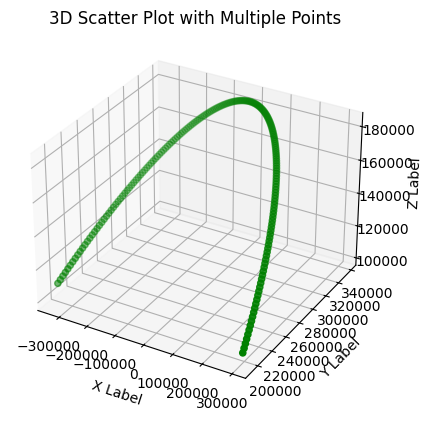

In [5]:
# Create a new figure
fig = plt.figure()

# Add a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Create a scatter plot
ax.scatter(x[:], y[:], z[:], c='g', marker='o')

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Set title
ax.set_title('3D Scatter Plot with Multiple Points')

# Show the plot
plt.show()

In [78]:
np.random.seed(5)

(70, 3)


I0000 00:00:1732638580.610762   10658 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732638580.635395   10658 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732638580.636754   10658 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732638580.638559   10658 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

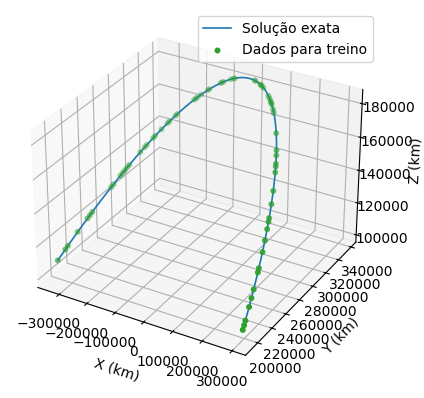

In [6]:
indices = random.sample(range(0,len(x)), 70)
indices_tf = tf.convert_to_tensor(indices, dtype=tf.int32)  # Convert indices to a TensorFlow tensor

X = tf.convert_to_tensor(x, dtype=tf.float64)
X = tf.expand_dims(X, 1)
Y = tf.convert_to_tensor(y, dtype=tf.float64)
Y = tf.expand_dims(Y, 1)
Z = tf.convert_to_tensor(z, dtype=tf.float64)
Z = tf.expand_dims(Z, 1)
t = np.linspace(0,len(X),len(X)+1)
T = tf.convert_to_tensor(t, dtype=tf.float64)
T = tf.expand_dims(T, 1)

Traj = tf.concat([X, Y,Z], axis=1)
x_data = tf.gather(T, indices_tf)  # Use TensorFlow's gather function for indexing
y_data = tf.gather(Traj, indices_tf)  # Use TensorFlow's gather function for indexing

print(y_data.shape)
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the exact solution
ax.plot(X, Y, Z, label="Solução exata",lw=1.2)

# Scatter plot for training data
ax.scatter(y_data[:, 0], y_data[:, 1], y_data[:, 2], color="tab:green", label="Dados para treino",s=10.7)

# Labels
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_zlabel('Z (km)')  # Add a z-label for the 3rd dimension

# Legend
ax.legend()

# Show plot
plt.show()

In [7]:
# x da EDO, com n pontos
n = 500
x_phys = tf.linspace(0,t[-1],n)
x_phys = tf.cast(x_phys, tf.float64)
x_phys = tf.expand_dims(x_phys, 1)

#G_pinn = tf.Variable(1e-3,trainable=True,dtype = tf.float64 ) Usado no começo
G_pinn = tf.Variable(0.1,trainable=True,dtype = tf.float64 )
G_original = tf.constant(6.6743e-11,dtype=tf.float64)
m_original = tf.constant(597.477882146e22, dtype=tf.float64)

#hiperparametros
tf.random.set_seed(5) #fixa a semente para cada teste ser igual
learning_rate = 0.00005
epochs = 100000 

k_phy_loss=(1e-4)


tf.keras.backend.set_floatx('float64')

# Arquiteruta do modelo neural, usando o keras
input_dim = 1
hidden_dim = 128
hidden_dim2 = 64
hidden_dim3 = 64
output_dim = 3

model_keras=Sequential([
    Dense(hidden_dim, input_dim=input_dim, use_bias=1,activation='tanh'),
    Dense(hidden_dim2, activation='tanh'),
    Dense(hidden_dim2, activation='tanh'),
    Dense(hidden_dim2, activation='exponential'),
    Dense(output_dim, activation="linear")
],name='rede_para_PINN')
model_keras.summary()

/home/henrique/codigos/tensorflow/tfgpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "rede_para_PINN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,027 (133.02 KB)

 Trainable params: 17,027 (133.02 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model_keras = tf.keras.models.load_model("modelos_de_verdade/moon_pinn_5090313108304_204.keras")
G_pinn = tf.Variable(5162624761726.328, trainable=True,dtype = tf.float64 )

In [21]:
learning_rate1 = 0.0001
learning_rate2 = 5e10

epochs = 100000 

k_phy_loss=(1e0)
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
optimizer2 = tf.optimizers.Adam(learning_rate=learning_rate2)

@tf.function
def training_step(x_data, y_data):
    batch_X = x_data
    batch_y = tf.convert_to_tensor(y_data, dtype='float64')
    
    with tf.GradientTape(persistent=True) as tape:
        yh = model_keras(batch_X) # Compute outputs for experimental points
        data_loss = tf.reduce_mean(tf.square(yh - batch_y))

        with tf.GradientTape() as t2:
            t2.watch(x_phys)
            with tf.GradientTape() as t1:
                t1.watch(x_phys)
                yhp = model_keras(x_phys) # Compute outputs for physics points
            dx  = tf.reshape(t1.batch_jacobian(yhp, x_phys), (-1, 3)) # Compute dy/dx
        dx2 = tf.reshape(t2.batch_jacobian(dx, x_phys), (-1, 3)) # Compute d^2y/dx^2
        x = yhp[:, 0]
        y = yhp[:, 1]
        z = yhp[:, 2]
        eps = tf.cast(tf.constant(1e-20), dtype=tf.float64)
        r = tf.sqrt(tf.square(x) + tf.square(y) + tf.square(z)) + eps
        vx = dx[:, 0]
        vy = dx[:, 1]
        vz = dx[:, 2]
        dvx = dx2[:, 0]
        dvy = dx2[:, 1]
        dvz = dx2[:, 2]   
        physics1 = tf.reduce_mean(tf.square(dvx + (G_pinn* x / (r**3))))
        physics2 = tf.reduce_mean(tf.square(dvy + (G_pinn * y / (r**3))))
        physics3 = tf.reduce_mean(tf.square(dvz + (G_pinn  * z / (r**3))))

        Phys_loss1 = k_phy_loss * physics1
        Phys_loss2 = k_phy_loss * physics2 
        Phys_loss3 = k_phy_loss * physics3 

        data_loss = tf.cast(data_loss, "float64")
        loss = data_loss + Phys_loss1 + Phys_loss2 + Phys_loss3 
    # Print intermediate values for debugging
    '''tf.print("Physics1 Loss:", Phys_loss1)
    tf.print("Physics2 Loss:", Phys_loss2)
    tf.print("Physics3 Loss:", Phys_loss3)
    tf.print("Data Loss:", data_loss)
    tf.print("Total Loss:", loss)
    tf.print("G_pinn:", G_pinn)'''
    gradients1 = tape.gradient(loss, model_keras.trainable_variables ) # Compute gradients  
    optimizer.apply_gradients(zip(gradients1, model_keras.trainable_variables)) # Apply gradients
    gradients2 = tape.gradient(loss, [G_pinn]) # Compute gradients  
    optimizer2.apply_gradients(zip(gradients2, [G_pinn]))
    


    return Phys_loss1, Phys_loss2, Phys_loss3, data_loss, loss, G_pinn

loss = training_step(x_data,y_data)
print(loss)


(<tf.Tensor: shape=(), dtype=float64, numpy=11.683426383429872>, <tf.Tensor: shape=(), dtype=float64, numpy=11.562258102821183>, <tf.Tensor: shape=(), dtype=float64, numpy=2.780271674737453>, <tf.Tensor: shape=(), dtype=float64, numpy=22971321.80328263>, <tf.Tensor: shape=(), dtype=float64, numpy=22971347.82923879>, <tf.Tensor: shape=(), dtype=float64, numpy=5162624538398.638>)


In [22]:
h_loss=[]
h_data_loss=[]
h_Phys_loss=[]
Gs = []
start_time = time.time()
for epoch in range(epochs):
    loss = training_step(x_data,y_data)
    l1,l2,l3,l4,l5,G_append = loss
    h_loss.append(l4)
    h_data_loss.append(l3)
    h_Phys_loss.append(l1+l2)
    Gs.append(G_append)
    if ((epoch+1)%500==0):
      print(f"Epoch {epoch + 1}/{epochs}, Loss: {l5}, Data Loss: {l4}, Physics Loss: {l1+l2+l3}")
      print(f"G previsto = {Gs[-1]:.11e}")
    if l4<=1e-8:
       break
print("--- %s seconds ---" % (time.time() - start_time))
print(f"G previsto = {Gs[-1]}")

Epoch 500/100000, Loss: 323.7054649503202, Data Loss: 320.1143593484714, Physics Loss: 3.591105601848853
G previsto = 5.16265643986e+12
Epoch 1000/100000, Loss: 314.16371355365766, Data Loss: 310.60911134643146, Physics Loss: 3.5546022072262096
G previsto = 5.16272020490e+12
Epoch 1500/100000, Loss: 307.47015032823003, Data Loss: 303.94877726106574, Physics Loss: 3.5213730671643195
G previsto = 5.16280062596e+12
Epoch 2000/100000, Loss: 74984.59133736897, Data Loss: 74979.41886684751, Physics Loss: 5.172470521457094
G previsto = 5.16289446753e+12
Epoch 2500/100000, Loss: 298.8677388421517, Data Loss: 295.39806530623935, Physics Loss: 3.4696735359123516
G previsto = 5.16299435739e+12
Epoch 3000/100000, Loss: 296.90890783805, Data Loss: 293.449420398359, Physics Loss: 3.45948743969105
G previsto = 5.16309779873e+12
Epoch 3500/100000, Loss: 295.0624319831133, Data Loss: 291.61211679042077, Physics Loss: 3.450315192692588
G previsto = 5.16320263591e+12
Epoch 4000/100000, Loss: 293.32619448

KeyboardInterrupt: 

In [17]:
G_original = tf.constant(6.6743e-20,dtype=tf.float64)
m_original = tf.constant(597.477882146e22, dtype=tf.float64)
print(f"{G_original*m_original:.11e},{Gs[-1]:.11e}")

3.98774662881e+05,5.17442394095e+12


In [155]:
model_keras.save("moon_pinn_5090313108304_204.keras")

In [182]:
print(f"{Gs[-1]:.11e}")

4.96284995973e+12


In [23]:
prev = np.array(model_keras.predict(tf.reshape(T,(-1,1)))).reshape(-1,3)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step


In [24]:
prev = np.array(model_keras.predict(tf.reshape(T,(-1,1)))).reshape(-1,3)
traj = (tf.concat((X,Y,Z),axis=1))
prev = (tf.convert_to_tensor(prev[:-1,:]))
print(tf.reduce_mean(prev-traj))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
tf.Tensor(-1.7918451114890706, shape=(), dtype=float64)


In [209]:
print(prev)
print(x[1],Y[1],Z[1])
print(tf.reduce_min(X))

tf.Tensor(
[[-0.94093985 -1.57798073  0.49317408]
 [-0.86165646 -2.23284018  1.15687568]
 [-0.81638971 -2.84268744  1.78930425]
 [-0.79096873 -3.34058289  2.30863822]
 [-0.78125303 -3.71042364  2.69296656]
 [-0.78267148 -3.97247643  2.96539792]
 [-0.79021128 -4.15619314  3.15887685]
 [-0.80021266 -4.28654571  3.30006511]
 [-0.81058869 -4.38138164  3.40713486]
 [-0.82033391 -4.45266217  3.49175258]
 [-0.8290412  -4.50823283  3.56129563]
 [-0.83659688 -4.55321821  3.62044484]
 [-0.84301919 -4.59097082  3.67220082]
 [-0.84838005 -4.62368822  3.71851053]
 [-0.85276899 -4.65281134  3.76065298]
 [-0.85627726 -4.67928357  3.79947912]
 [-0.85899124 -4.70372095  3.83556341]
 [-0.86099024 -4.72652491  3.86930082]
 [-0.8623464  -4.74795728  3.90096967]
 [-0.86312539 -4.76819008  3.9307725 ]
 [-0.8633874  -4.78733844  3.95886277]
 [-0.86318807 -4.80548208  3.98536222]
 [-0.86257931 -4.8226793   4.01037207]
 [-0.86160988 -4.83897572  4.03398018]
 [-0.86032573 -4.85440985  4.05626553]
 [-0.85877027 

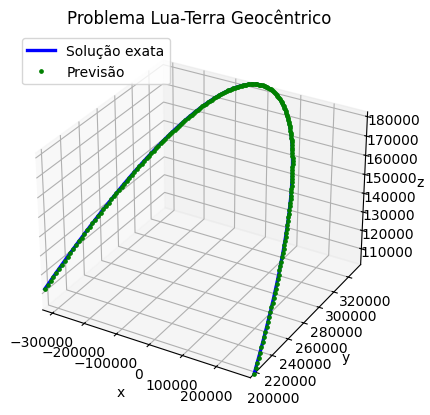

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot the exact solution
n,m = 0,-1
ax.plot(X[n:m], Y[n:m], Z[n:m], "b-",label="Solução exata",lw = 2.4,markersize=2.4)

# Scatter plot for training data
ax.plot(prev[n:m, 0], prev[n:m, 1], prev[n:m, 2], "go", label="Previsão",markersize=2.4)

# Labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')  # Add a z-label for the 3rd dimension
ax.set_xlim([tf.reduce_min(X), tf.reduce_max(X)])
ax.set_ylim([tf.reduce_min(Y), tf.reduce_max(Y)])
ax.set_zlim([tf.reduce_min(Z), tf.reduce_max(Z)])

# Legend
plt.title("Problema Lua-Terra Geocêntrico")
ax.legend()
#plt.savefig("moon.pdf")
# Show plot
plt.show()